<a href="https://colab.research.google.com/github/Hadrien-Cornier/cool-nn-stuff/blob/main/aleatoric_vs_epistemic_uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install tensorflow tf-keras tensorflow_probability matplotlib seaborn scikit-learn -q

In [20]:
import numpy as np

for base_prob in [0.1, 0.2, 0.3, 0.4, 0.5]:

    # Number of samples for simulation
    num_samples = 10000

    # Generate samples for c
    c_samples = np.random.uniform(0, 1, num_samples)

    # Compute the expression for each sample
    values = np.clip(base_prob + base_prob * np.sin(c_samples * np.pi), 0.01, 0.99)

    # Calculate the variance of the resulting values
    variance = np.var(values)

    print(f"base_prob = {base_prob}, Estimated Stdev: {variance**0.5}")


base_prob = 0.1, Estimated Stdev: 0.03079355742766971
base_prob = 0.2, Estimated Stdev: 0.06139805740868671
base_prob = 0.3, Estimated Stdev: 0.09248132741921093
base_prob = 0.4, Estimated Stdev: 0.12405102702227322
base_prob = 0.5, Estimated Stdev: 0.15232248026712936


In [21]:
# Set random seeds for reproducibility
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)

# True probabilities based on feature combinations
true_class_prob_var = {
        ('A', 'X'): {"prob" : 0.1, "stdev" : 0.030952139346463268} ,
        ('A', 'Y'): {"prob" : 0.2, "stdev" : 0.06119698957156734},
        ('B', 'X'): {"prob": 0.3, "stdev": 0.09229488469895951},
        ('B', 'Y'): {"prob": 0.5, "stdev": 0.15374131852930115}
    }

def true_prob(c1, c2, c):
    base_prob = true_class_prob_var[(c1, c2)]["prob"]
    return np.clip(base_prob + base_prob * np.sin(c * np.pi), 0.01, 0.99)

# Generate synthetic data
def generate_data(n_samples=10000):
    # Categorical features
    cat1 = np.random.choice(['A', 'B'], n_samples)
    cat2 = np.random.choice(['X', 'Y'], n_samples)

    # Continuous feature
    cont = np.random.uniform(0, 1, n_samples)

    probs = np.array([true_prob(c1, c2, c) for c1, c2, c in zip(cat1, cat2, cont)])
    vars = np.array([true_prob(c1, c2, c) for c1, c2, c in zip(cat1, cat2, cont)])
    # Generate target variable with aleatoric uncertainty
    y = np.random.binomial(1, probs)

    return (cat1, cat2, cont), y, probs, vars

# Generate data
(cat1, cat2, cont), y, true_probs, true_vars = generate_data()

# Separate in-distribution (A) and out-of-distribution (B) data
mask_in_dist = (cat1 == 'A')
mask_out_dist = (cat1 == 'B')

# In-distribution data (A)
cat1_in = cat1[mask_in_dist]
cat2_in = cat2[mask_in_dist]
cont_in = cont[mask_in_dist]
y_in = y[mask_in_dist]

# Out-of-distribution data (B)
cat1_out = cat1[mask_out_dist]
cat2_out = cat2[mask_out_dist]
cont_out = cont[mask_out_dist]
y_out = y[mask_out_dist]

# Preprocess in-distribution data
cat1_in_encoded = tf.keras.utils.to_categorical(np.searchsorted(['A', 'B'], cat1_in), num_classes=2)
cat2_in_encoded = tf.keras.utils.to_categorical(np.searchsorted(['X', 'Y'], cat2_in), num_classes=2)
X_in = np.hstack([cat1_in_encoded, cat2_in_encoded, cont_in.reshape(-1, 1)])

# Preprocess out-of-distribution data
cat1_out_encoded = tf.keras.utils.to_categorical(np.searchsorted(['A', 'B'], cat1_out), num_classes=2)
cat2_out_encoded = tf.keras.utils.to_categorical(np.searchsorted(['X', 'Y'], cat2_out), num_classes=2)
X_out = np.hstack([cat1_out_encoded, cat2_out_encoded, cont_out.reshape(-1, 1)])

# Split in-distribution data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_in, y_in, test_size=0.2, random_state=42)

# Validation set from out-of-distribution data
X_val = X_out
y_val = y_out

# Create model
def create_beta_bernoulli_model():
    inputs = tf.keras.Input(shape=(5,))
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    alpha = tf.keras.layers.Dense(1, activation='softplus', name='alpha')(x) + 1.0  # Name output layers
    beta = tf.keras.layers.Dense(1, activation='softplus', name='beta')(x) + 1.0
    return tf.keras.Model(inputs=inputs, outputs=tf.keras.layers.Concatenate()([alpha, beta]), name='BetaBernoulliModel')

# Custom loss function (negative log likelihood of Beta-Bernoulli distribution)
def nll_beta_bernoulli(y_true, y_pred):
    alpha = y_pred[:, 0]
    beta = y_pred[:, 1]
    tfd = tfp.distributions
    # Define the Beta distribution
    beta_dist = tfd.Beta(concentration1=alpha, concentration0=beta)
    # Sample p from the Beta distribution
    p = beta_dist.sample()
    # Define the Bernoulli distribution with the sampled p
    bernoulli_dist = tfd.Bernoulli(probs=p)
    # Compute the log likelihood
    log_likelihood = bernoulli_dist.log_prob(y_true)
    # Compute the negative log likelihood
    nll = -tf.reduce_mean(log_likelihood)
    # Regularization term to ensure alpha and beta do not explode
    regularization = 1e-1 * (alpha + beta)
    return nll + regularization

# Custom accuracy metric for Beta-Bernoulli model
def beta_bernoulli_accuracy(y_true, y_pred):
    alpha = y_pred[:, 0]
    beta = y_pred[:, 1]
    mean = alpha / (alpha + beta)
    return tf.keras.metrics.binary_accuracy(y_true, mean)

# Create model with dropout
def create_model_with_dropout():
    inputs = tf.keras.Input(shape=(5,))
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name='monte_carlo_dropout')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Create and compile the single pass uncertainty estimation model
model_single_pass = create_beta_bernoulli_model()
model_single_pass.compile(loss=nll_beta_bernoulli, optimizer='adam',  metrics=[beta_bernoulli_accuracy])
model_single_pass.summary()
model_single_pass.fit(X_train, y_train.reshape(-1, 1), validation_data=(X_val, y_val.reshape(-1, 1)), batch_size=1024, epochs=20, verbose=1, callbacks=[early_stopping])

# Create and compile the multi-pass uncertainty estimation model
model_multi_pass = create_model_with_dropout()
model_multi_pass.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_multi_pass.summary()
model_multi_pass.fit(X_train, y_train.reshape(-1, 1), validation_data=(X_val, y_val.reshape(-1, 1)), epochs=20, batch_size=1024, verbose=1, callbacks=[early_stopping])

# Predict mean and variance for single pass model
def predict_single_pass(model, X):
    if X.shape[1] != model.input_shape[1]:
        raise ValueError(f"Input shape mismatch: expected {model.input_shape[1]}, got {X.shape[1]}")
    y_pred = model.predict(X)
    alpha = y_pred[:, 0]
    beta = y_pred[:, 1]
    mean = alpha / (alpha + beta)
    variance = alpha * beta / ((alpha + beta)**2 * (alpha + beta + 1))
    assert mean.shape == variance.shape
    return mean, variance

# Predict mean and variance for multi-pass model using Monte Carlo Dropout
def predict_multi_pass(model, X, n_samples=64):
    preds = np.array([model.predict(X) for _ in range(n_samples)])
    mean = np.mean(preds, axis=0)
    variance = np.var(preds, axis=0)
    return mean, variance

# Get predictions
mean_single_in, var_single_in = predict_single_pass(model_single_pass, X_train)
mean_single_out, var_single_out = predict_single_pass(model_single_pass, X_val)
mean_multi_in, var_multi_in = predict_multi_pass(model_multi_pass, X_train)
mean_multi_out, var_multi_out = predict_multi_pass(model_multi_pass, X_val)

def decode_one_hot(encoded_vector):
    cat1_label = 'A' if encoded_vector[0] == 1 else 'B'
    cat2_label = 'X' if encoded_vector[2] == 1 else 'Y'
    return f"{cat1_label},{cat2_label}"

# Generate class labels for input data
class_labels_in = [decode_one_hot(x) for x in X_train]
class_labels_out = [decode_one_hot(x) for x in X_val]

Model: "BetaBernoulliModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 dense_22 (Dense)            (None, 64)                   384       ['input_7[0][0]']             
                                                                                                  
 dense_23 (Dense)            (None, 64)                   4160      ['dense_22[0][0]']            
                                                                                                  
 alpha (Dense)               (None, 1)                    65        ['dense_23[0][0]']            
                                                                                 

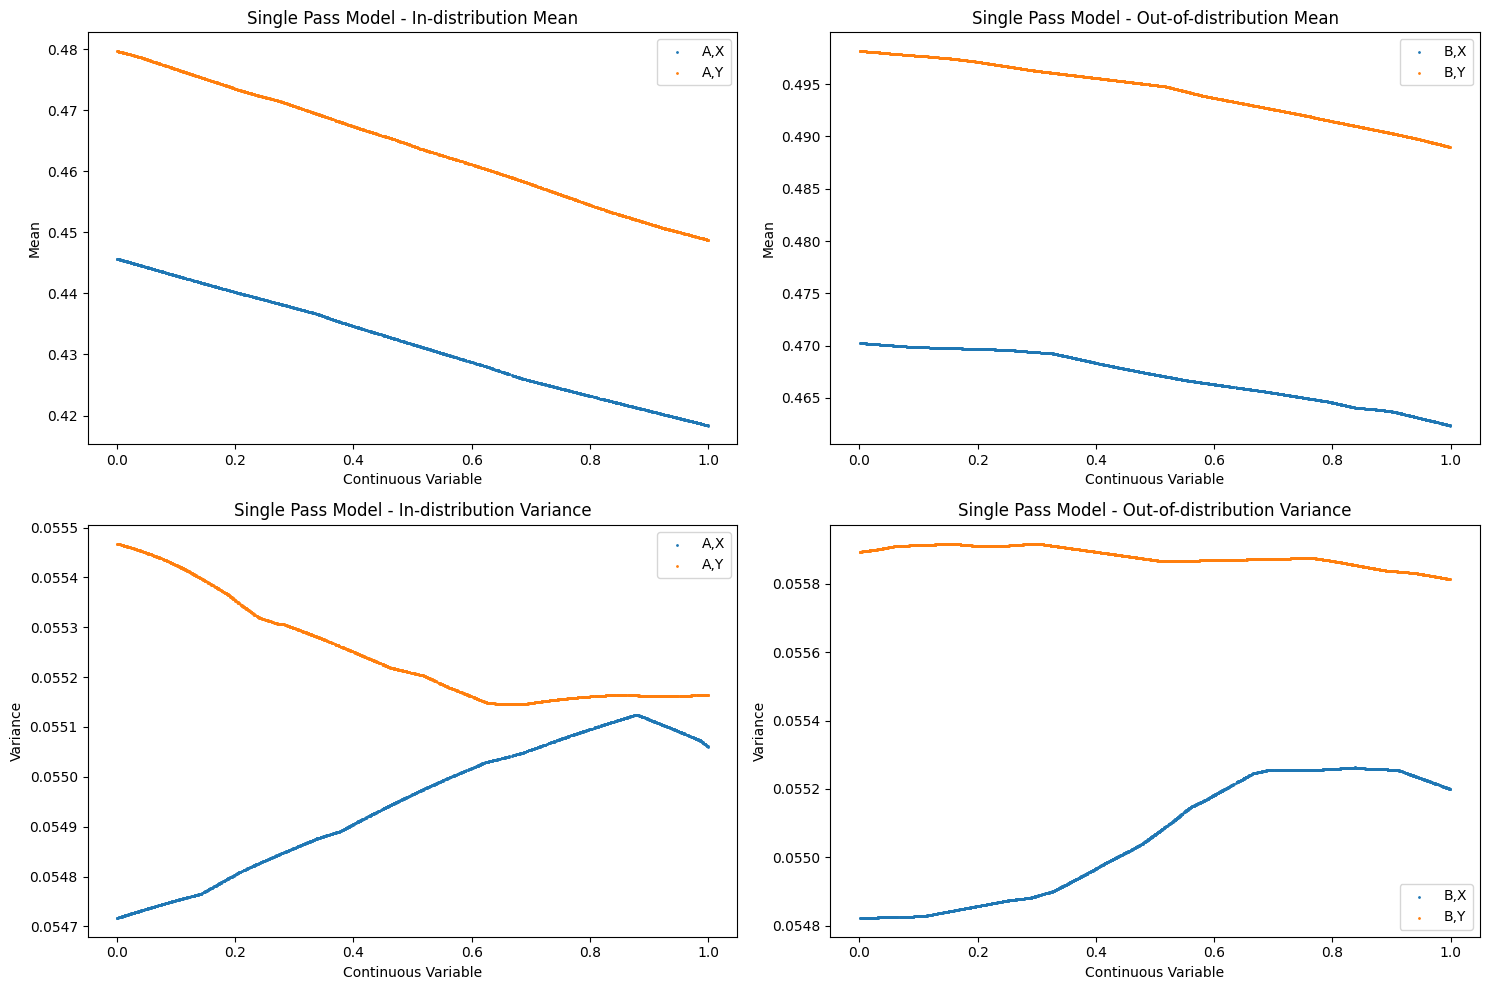

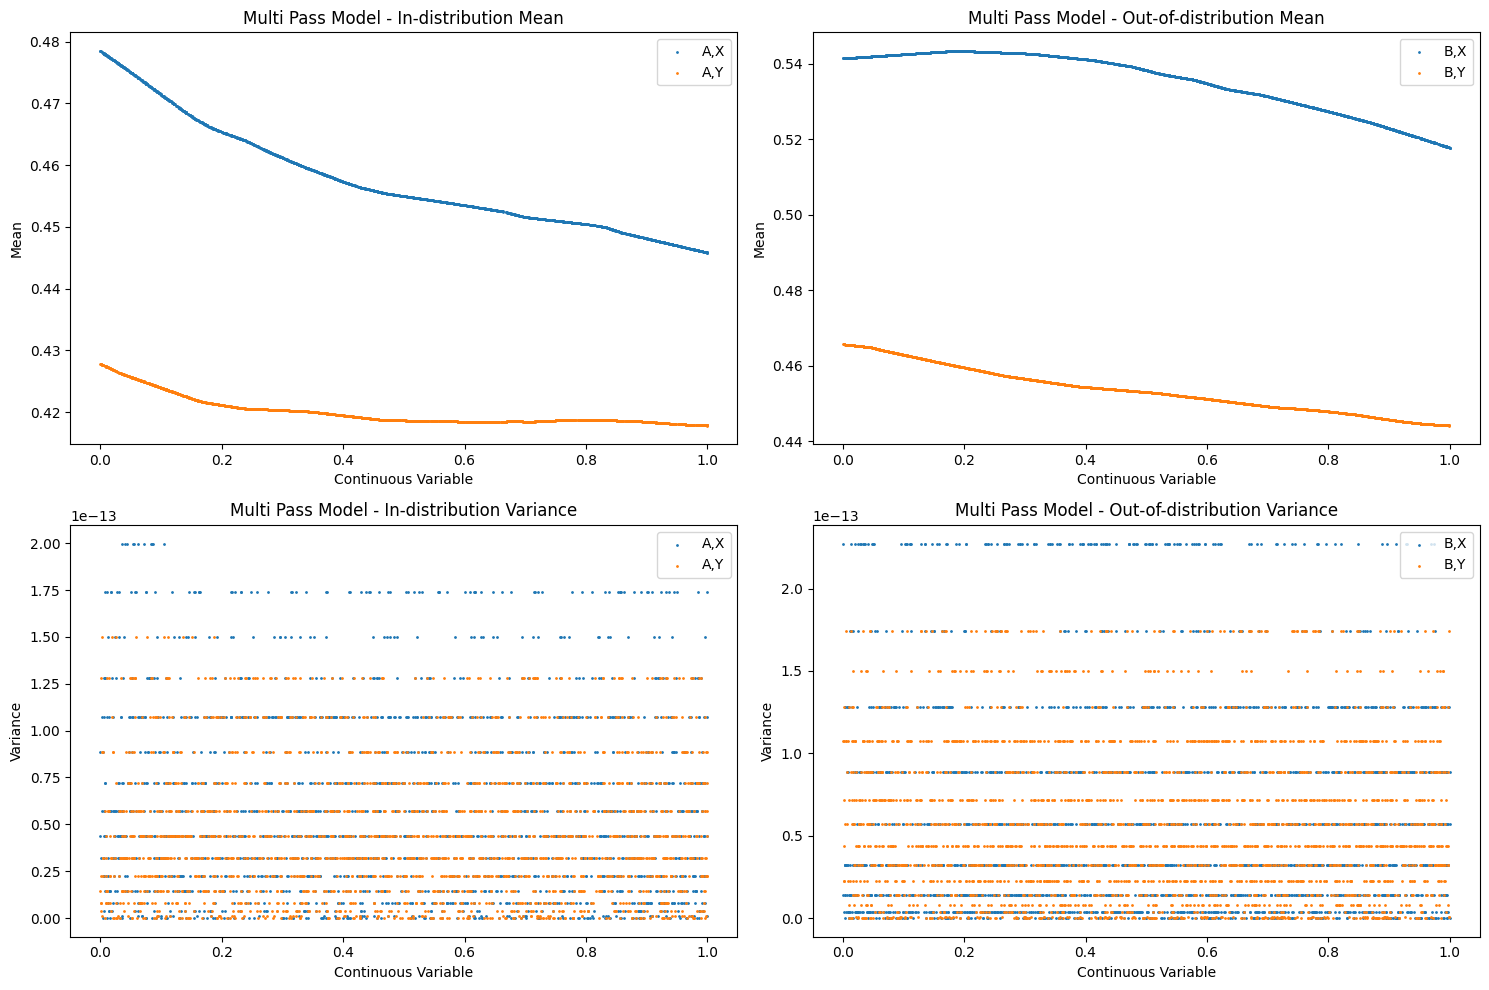

In [22]:
# Ensure the lengths of the arrays match
cont_in = X_train[:, -1]
cont_out = X_val[:, -1]
assert len(cont_in) == len(mean_single_in) == len(var_single_in) == len(class_labels_in)
assert len(cont_out) == len(mean_single_out) == len(var_single_out) == len(class_labels_out)

# Plotting function with class labels
def plot_results(cont_in, mean_in, var_in, cont_out, mean_out, var_out, class_labels_in, class_labels_out, title):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # In-distribution Mean
    for label in np.unique(class_labels_in):
        mask = np.array(class_labels_in) == label
        axs[0, 0].scatter(cont_in[mask], mean_in[mask], s=1, label=f'{label}')
    axs[0, 0].set_title(f'{title} - In-distribution Mean')
    axs[0, 0].set_xlabel('Continuous Variable')
    axs[0, 0].set_ylabel('Mean')
    axs[0, 0].legend()

    # Out-of-distribution Mean
    for label in np.unique(class_labels_out):
        mask = np.array(class_labels_out) == label
        axs[0, 1].scatter(cont_out[mask], mean_out[mask], s=1, label=f'{label}')
    axs[0, 1].set_title(f'{title} - Out-of-distribution Mean')
    axs[0, 1].set_xlabel('Continuous Variable')
    axs[0, 1].set_ylabel('Mean')
    axs[0, 1].legend()

    # In-distribution Variance
    for label in np.unique(class_labels_in):
        mask = np.array(class_labels_in) == label
        axs[1, 0].scatter(cont_in[mask], var_in[mask], s=1, label=f'{label}')
    axs[1, 0].set_title(f'{title} - In-distribution Variance')
    axs[1, 0].set_xlabel('Continuous Variable')
    axs[1, 0].set_ylabel('Variance')
    axs[1, 0].legend()

    # Out-of-distribution Variance
    for label in np.unique(class_labels_out):
        mask = np.array(class_labels_out) == label
        axs[1, 1].scatter(cont_out[mask], var_out[mask], s=1, label=f'{label}')
    axs[1, 1].set_title(f'{title} - Out-of-distribution Variance')
    axs[1, 1].set_xlabel('Continuous Variable')
    axs[1, 1].set_ylabel('Variance')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

# Plot results for single pass model
plot_results(cont_in, mean_single_in, var_single_in, cont_out, mean_single_out, var_single_out, class_labels_in, class_labels_out, 'Single Pass Model')

# Plot results for multi-pass model
plot_results(cont_in, mean_multi_in, var_multi_in, cont_out, mean_multi_out, var_multi_out, class_labels_in, class_labels_out, 'Multi Pass Model')